#### Funcitons (IGNORE)

In [1]:
# import packages that will be used for analysis
import random
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

##### Get Stock Data

In [2]:
import yfinance as yf
missing_data_tickers = [] # use this as a list of tickers with missing data

def get_data_from_start_to_end(ticker, start_date, end_date):
    global missing_data_tickers  # Use the global list to accumulate missing tickers
    try:
        stock_data = yf.download(ticker, start=start_date, end=end_date)
        if stock_data.empty:
            missing_data_tickers.append(ticker)
            raise ValueError(f"Stock data for ticker {ticker} during the period from {start_date} to {end_date} was not found.")
        return stock_data
    except Exception as e:
        print(f"An error occurred for ticker {ticker}: {e}")
        missing_data_tickers.append(ticker)
        return None


In [3]:
# for a variety of periods load in different list of tickers
def download_stock_data_for_periods(tickers, periods):
    all_data = {}
    
    for period, (start_date, end_date) in periods.items():
        period_data = {}
        for ticker in tickers:
            data = get_data_from_start_to_end(ticker, start_date, end_date)
            if data is not None:
                period_data[ticker] = data
        all_data[period] = period_data
    
    return all_data

In [4]:
import pandas as pd

# Get the adjusted close prices
adj_close_sector_etf = {}

# Create adjusted close price only listing of sector ETFs
def get_adjusted_closed_price(nested_dict, tickers, periods):
    for period in periods:
        stock_price_df = pd.DataFrame()  # Create a new DataFrame for each period
        for ticker in tickers:
            stock_price_df[ticker] = nested_dict[period][ticker]['Adj Close']
        
        adj_close_sector_etf[period] = stock_price_df  # Store the complete DataFrame for the period
    
    return adj_close_sector_etf

##### MACD Signal

In [5]:
def macd_components(nested_dict,periods,tickers):
    for period in periods:
        for ticker in tickers:
            # get the short and long ema
            nested_dict[period][ticker]['short_ema'] = nested_dict[period][ticker]['Close'].ewm(span=12, adjust=False).mean()
            nested_dict[period][ticker]['long_ema'] = nested_dict[period][ticker]['Close'].ewm(span=26, adjust=False).mean()

            # create the MACD line
            nested_dict[period][ticker]['macd_line'] = nested_dict[period][ticker]['short_ema'] - nested_dict[period][ticker]['long_ema']
            nested_dict[period][ticker]['signal_line'] = nested_dict[period][ticker]['macd_line'].ewm(span=9, adjust=False).mean()

    return nested_dict

In [6]:
def generate_signals(nested_dict, periods, tickers):
    for period in periods:
        for ticker in tickers:
            # Create lists to store buy and sell signals
            buy_signals = []
            sell_signals = []

            # Initialize variables to track the last state (to detect crossovers)
            last_macd_above_signal = None

            # Loop through each row in the MACD dataframe
            for i in range(len(nested_dict[period][ticker]['macd_line'])):
                macd_line = nested_dict[period][ticker]['macd_line'].iloc[i]
                signal_line = nested_dict[period][ticker]['signal_line'].iloc[i]

                # Determine buy/sell signal based on MACD crossover
                if macd_line > signal_line and (last_macd_above_signal is False or last_macd_above_signal is None):
                    buy_signals.append(nested_dict[period][ticker]['Close'].iloc[i])
                    sell_signals.append(None)
                    last_macd_above_signal = True
                elif macd_line < signal_line and (last_macd_above_signal is True or last_macd_above_signal is None):
                    sell_signals.append(nested_dict[period][ticker]['Close'].iloc[i])
                    buy_signals.append(None)
                    last_macd_above_signal = False
                else:
                    # No signal
                    buy_signals.append(None)
                    sell_signals.append(None)

            # Store buy and sell signals in the nested dictionary
            nested_dict[period][ticker]['buy_signals'] = buy_signals
            nested_dict[period][ticker]['sell_signals'] = sell_signals

    return nested_dict


# Moving Average Convergence Divergence (MACD)
The MACD is another popular technical analysis technique, it concentrates on the momentum of a stock. It has two lines which oscillate between one another. The first line, referred to as the MACD line is found by looking at longer term EMA (typically 26) / shorter term EMA (typically 12). The second line is referred to as the signal line which is typically a 9 day EMA of the MACD line. It can suggest the following:

- Bullish Signal: When the MACD Line crosses above the Signal Line, it can indicate upward momentum, a possible buy signal.
- Bearish Signal: When the MACD Line crosses below the Signal Line, it can indicate downward momentum, a possible sell signal.
- Divergence: Price action diverging from the MACD can signal potential reversals.

In [7]:
# create time periods for where this takes place
economic_cycle_periods = {

    "trough": ("2008-10-01", "2009-06-01"),
    "expansion": ("2012-01-01", "2015-01-01"),
    "peak": ("2019-06-01", "2020-02-01"),
    "contraction": ("2007-12-01", "2008-10-01"),
    'all_data': ('2005-01-01','2024-06-01')
}

economic_cycle_periods_list = ['trough','expansion','peak','contraction','all_data']

In [8]:
# create etf tickers for sectors
sector_etf_tickers = [
    'XLB', # materials sector
    'XLI', # industrials sector
    'XLF', # financials
    'XLK', # information technology
    'XLY', # consumer discretionary
    'XLP', # consumer staples
    'XLE', # energy
    'XLV', # healthcare
    'VOX', # communication services
    'XLU', # utilities
    'IYR' # real estate
    ]

In [9]:
# save nested dictionary data as a variable to be accessed.
sector_etf_data = download_stock_data_for_periods(sector_etf_tickers,economic_cycle_periods)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [10]:
macd_components(sector_etf_data,economic_cycle_periods_list,sector_etf_tickers)

{'trough': {'XLB':                  Open       High        Low      Close  Adj Close    Volume  \
  Date                                                                          
  2008-10-01  32.759998  33.189999  32.130001  32.849998  23.119263  14639500   
  2008-10-02  31.540001  31.860001  29.930000  30.490000  21.458336  12581300   
  2008-10-03  30.190001  31.690001  29.780001  30.190001  21.247206  16770600   
  2008-10-06  29.510000  29.510000  26.889999  28.700001  20.198568  22512700   
  2008-10-07  29.160000  29.530001  27.049999  27.219999  19.156971  16004900   
  ...               ...        ...        ...        ...        ...       ...   
  2009-05-22  26.530001  26.660000  26.110001  26.299999  18.848721   8421500   
  2009-05-26  26.170000  26.969999  25.830000  26.930000  19.300226   7886900   
  2009-05-27  26.790001  26.850000  25.860001  25.920000  18.576378   7216600   
  2009-05-28  26.190001  26.440001  25.760000  26.379999  18.906046   8773400   
  2009-05-2

In [11]:
def add_macd_signals(nested_dict,periods, tickers, short_window=12, long_window=26, signal_window=9):
    """
    Function to calculate MACD, Signal Line, and generate Buy/Sell/Hold signals based on crossovers.
    """
    for period in periods:
        for ticker in tickers:

            data = nested_dict[period][ticker]

            # Generate 'Buy', 'Sell', 'Hold' signals using np.where() based on crossovers
            data['Signal'] = np.where(data['macd_line'] > data['signal_line'], 'Buy', 
                                    np.where(data['macd_line'] < data['signal_line'], 'Sell', 'Hold'))

    return nested_dict

In [12]:
add_macd_signals(sector_etf_data,economic_cycle_periods_list,sector_etf_tickers)

{'trough': {'XLB':                  Open       High        Low      Close  Adj Close    Volume  \
  Date                                                                          
  2008-10-01  32.759998  33.189999  32.130001  32.849998  23.119263  14639500   
  2008-10-02  31.540001  31.860001  29.930000  30.490000  21.458336  12581300   
  2008-10-03  30.190001  31.690001  29.780001  30.190001  21.247206  16770600   
  2008-10-06  29.510000  29.510000  26.889999  28.700001  20.198568  22512700   
  2008-10-07  29.160000  29.530001  27.049999  27.219999  19.156971  16004900   
  ...               ...        ...        ...        ...        ...       ...   
  2009-05-22  26.530001  26.660000  26.110001  26.299999  18.848721   8421500   
  2009-05-26  26.170000  26.969999  25.830000  26.930000  19.300226   7886900   
  2009-05-27  26.790001  26.850000  25.860001  25.920000  18.576378   7216600   
  2009-05-28  26.190001  26.440001  25.760000  26.379999  18.906046   8773400   
  2009-05-2

In [15]:
sector_etf_data['expansion']['XLV']['Signal'].value_counts()

Buy     386
Sell    367
Hold      1
Name: Signal, dtype: int64

In [16]:
def collect_signals(nested_dict, periods, tickers):
    # Initialize an empty dictionary to hold DataFrames for each period
    bb_nested_dict = {}

    for period in periods:
        # Create a DataFrame for each period with the tickers as columns
        signals_period = pd.DataFrame(columns=tickers)
        
        # Loop through each ticker and extract the 'Signal'
        for ticker in tickers:
            signals_period[ticker] = nested_dict[period][ticker]['Signal']
        
        # Store the DataFrame in the dictionary using the period as the key
        bb_nested_dict[period] = signals_period

    # Return the dictionary containing DataFrames for each period
    return bb_nested_dict

In [17]:
macd_signals = collect_signals(sector_etf_data,economic_cycle_periods_list,sector_etf_tickers)

In [19]:
import pandas as pd
import numpy as np
from datetime import timedelta
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

def portfolio_investment(bb_signals_nd, adj_close_nd, periods_date, periods_list, tickers, n_sample, initial_investment, percent_to_buy, percent_to_sell):
    # Track actions day by day for the entire portfolio
    portfolio_tracker = {period: pd.DataFrame(columns=['Date', 'Account Balance', 'Portfolio Value', 'Total Value', 'Profit', 'Sector Allocation']) for period in periods_list}

    # Portfolio summary - nested dictionary for each period and ticker
    portfolio_summary = {period: {ticker: pd.DataFrame() for ticker in tickers} for period in periods_list}
  
    # Set data to be accessed
    adj_close_data = adj_close_nd
    bollinger_band_data = bb_signals_nd

    all_data = {
        'Stock Tracker': portfolio_summary,
        'Portfolio Tracker': portfolio_tracker,
        'Adjusted Close Price': adj_close_nd,
        'Bollinger Band Signal': bollinger_band_data
    }

    # Loop through each economic period
    for period in periods_list:
        # Create the date range for the current period
        date_range = pd.date_range(start=pd.to_datetime(periods_date[period][0]), end=pd.to_datetime(periods_date[period][1]) - timedelta(days=90))
        # Get random dates for stochastic modeling
        start_dates = np.random.choice(date_range, size=n_sample, replace=False)

        # Loop through sampled start dates
        for start_date in start_dates:
            time_stamp = pd.to_datetime(start_date)

            # Initialize balance for portfolio investment  
            account_balance = initial_investment
            shares_number = {ticker: 0 for ticker in tickers}  # Initialize share count for each ticker

            # Extract the adjusted close and signal data for time period
            adj_close_period = adj_close_data[period].loc[time_stamp:time_stamp + timedelta(days=90)]
            bb_signals_period = bollinger_band_data[period].loc[time_stamp:time_stamp + timedelta(days=90)]

            # Iterate over each row in the Bollinger Band signals (day by day)
            for row_idx, row in bb_signals_period.iterrows():
                daily_balance_change = 0
                portfolio_value = 0

                # Initialize tracking for each ticker
                for col_idx, signal in enumerate(row):
                    ticker = tickers[col_idx]  # Correctly get ticker for each column
                    adj_close_price = adj_close_period.loc[row_idx, ticker]  # Get corresponding adjusted close price

                    # Initialize stock tracker for current ticker
                    stock_tracker = all_data['Stock Tracker'][period][ticker]

                    # Handle Buy action
                    if signal == 'Buy':
                        amount_to_buy = percent_to_buy * account_balance
                        if account_balance >= amount_to_buy:
                            # Calculate shares to buy
                            shares_to_buy = amount_to_buy / adj_close_price
                            shares_number[ticker] += shares_to_buy

                            # Track investment for the current period
                            stock_tracker = stock_tracker.append({
                                'Date': row_idx,
                                'Share Price': adj_close_price,
                                'Signal': 'Buy',
                                'Buy/Sell Amount ($)': amount_to_buy,
                                'Buy/Sell Number of Shares': shares_to_buy,
                                'Shares ($) Ownership': shares_number[ticker] * adj_close_price,  # Update based on current price
                                'Shares Ownership': shares_number[ticker]
                            }, ignore_index=True)

                            # Update account balance after buying
                            account_balance -= amount_to_buy

                    # Handle Sell action
                    elif signal == 'Sell':
                        if shares_number[ticker] > 0:  # Ensure we have shares to sell
                            amount_to_sell = percent_to_sell * (shares_number[ticker] * adj_close_price)
                            shares_to_sell = amount_to_sell / adj_close_price
                            if shares_number[ticker] >= shares_to_sell:
                                shares_number[ticker] -= shares_to_sell

                                # Track the sell action
                                stock_tracker = stock_tracker.append({
                                    'Date': row_idx,
                                    'Share Price': adj_close_price,
                                    'Signal': 'Sell',
                                    'Buy/Sell Amount ($)': amount_to_sell,
                                    'Buy/Sell Number of Shares': shares_to_sell,
                                    'Shares ($) Ownership': shares_number[ticker] * adj_close_price,  # Update based on current price
                                    'Shares Ownership': shares_number[ticker]
                                }, ignore_index=True)

                                # Update account balance after selling
                                account_balance += amount_to_sell

                    # Handle Hold action (no action taken)
                    else:
                        # Track the hold state
                        stock_tracker = stock_tracker.append({
                            'Date': row_idx,
                            'Share Price': adj_close_price,
                            'Signal': 'Hold',
                            'Buy/Sell Amount ($)': 0,
                            'Buy/Sell Number of Shares': 0,
                            'Shares ($) Ownership': shares_number[ticker] * adj_close_price,  # Update based on current price
                            'Shares Ownership': shares_number[ticker]
                        }, ignore_index=True)

                    # Save the updated tracker back to portfolio summary
                    all_data['Stock Tracker'][period][ticker] = stock_tracker.copy()

                # Calculate total portfolio value for all tickers for the day
                portfolio_value = sum(shares_number[ticker] * adj_close_period.loc[row_idx, ticker] for ticker in tickers)

                # Total value (account balance + portfolio value)
                total_value = account_balance + portfolio_value

                # Calculate profit (difference from initial investment)
                profit = total_value - initial_investment

                # Calculate percentage allocation of each ticker to total portfolio value
                sector_allocation = {ticker: (shares_number[ticker] * adj_close_period.loc[row_idx, ticker]) / portfolio_value * 100 if portfolio_value > 0 else 0 for ticker in tickers}

                # Track portfolio changes for the current day
                portfolio_tracker[period] = portfolio_tracker[period].append({
                    'Date': row_idx,
                    'Account Balance': account_balance,
                    'Portfolio Value': portfolio_value,
                    'Total Value': total_value,
                    'Profit': profit,
                    'Sector Allocation': sector_allocation
                }, ignore_index=True)

            # Update the portfolio tracker for the period
            all_data['Portfolio Tracker'][period] = portfolio_tracker[period]

    # Return the complete portfolio summary for all periods and tickers
    return all_data

In [20]:
adj_close_sector_etf = get_adjusted_closed_price(sector_etf_data,sector_etf_tickers,economic_cycle_periods_list)

In [22]:
macd_investment = portfolio_investment(macd_signals,adj_close_sector_etf,economic_cycle_periods,economic_cycle_periods_list,sector_etf_tickers,1,100000,0.01,0.01)

In [30]:
macd_investment['Stock Tracker']['expansion']['XLF']

,Date,Share Price,Signal,Buy/Sell Amount ($),Buy/Sell Number of Shares,Shares ($) Ownership,Shares Ownership
0,2013-01-28,11.340614,Buy,990.000000,87.296858,990.000000,87.296858
1,2013-01-29,11.386237,Buy,904.382075,79.427651,1898.364804,166.724510
2,2013-01-30,11.334095,Sell,18.896714,1.667245,1870.774717,165.057265
3,2013-01-31,11.327579,Sell,18.696993,1.650573,1851.002293,163.406692
4,2013-02-01,11.477484,Sell,18.754977,1.634067,1856.742674,161.772625
...,...,...,...,...,...,...,...
58,2013-04-22,11.836623,Sell,37.014117,3.127084,3664.397614,309.581335
59,2013-04-23,12.052427,Sell,37.312065,3.095813,3693.894470,306.485522
60,2013-04-24,12.124362,Buy,107.043104,8.828762,3822.984517,315.314284
61,2013-04-25,12.196299,Buy,104.035834,8.530115,3949.702991,323.844399


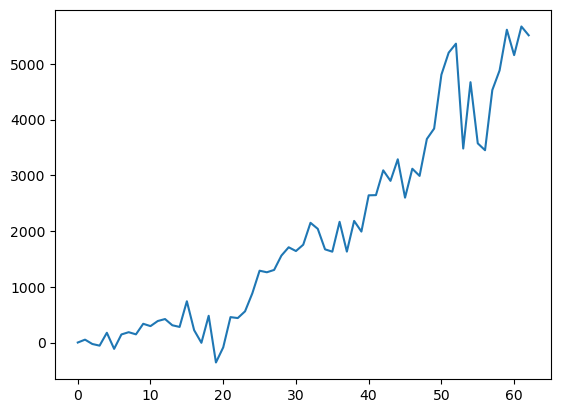

In [37]:
plt.plot(macd_investment['Portfolio Tracker']['expansion']['Profit'])